In [462]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats.mstats import winsorize
from scipy.stats import median_abs_deviation
from sklearn.preprocessing import MinMaxScaler

In [463]:
df_incidents = pd.read_csv('incidents-clean.csv')

df_incidents.drop(columns=[
    'INCIDENT_NBR',
    'INCIDENT_TYPE_DESC',
    'DESCRIPTION_GROUPE',
    'NOM_VILLE',
    'NOM_ARROND',
    'DIVISION',
    'LATITUDE',
    'LONGITUDE'
], inplace=True)

df_incidents['CREATION_DATE'] = pd.to_datetime(df_incidents['CREATION_DATE'])
df_incidents['YEAR'] = df_incidents['CREATION_DATE'].dt.year
df_incidents['MONTH'] = df_incidents['CREATION_DATE'].dt.month

df_incidents = df_incidents.drop(columns=['CREATION_DATE'])
df_incidents = df_incidents[df_incidents['YEAR'] < 2025]
df_incidents = df_incidents[["YEAR", "MONTH", "CASERNE", "NOMBRE_UNITES", "DESC_GROUP_ENGLISH"]]
df_incidents.head()

,YEAR,MONTH,CASERNE,NOMBRE_UNITES,DESC_GROUP_ENGLISH
0,2005,1,22,4.0,Other fires
1,2005,1,47,1.0,Other fires
2,2005,1,43,4.0,Other fires
3,2005,1,15,7.0,Building fire
4,2005,1,41,8.0,Building fire


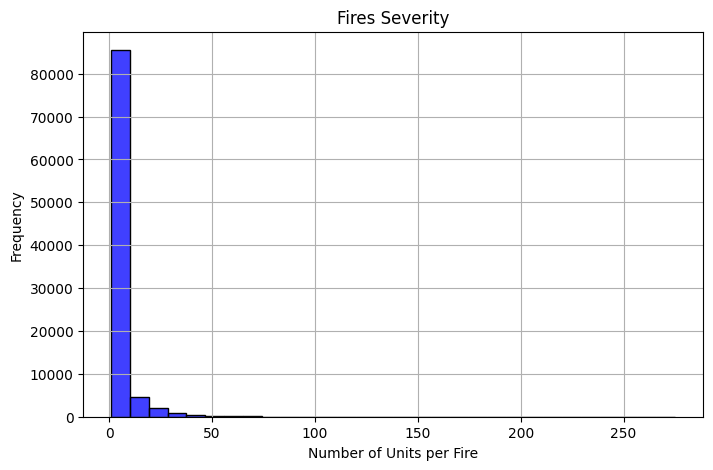

In [464]:
# --- ️Overall Fires Severity Distribution ---
plt.figure(figsize=(8, 5))
sns.histplot(df_incidents["NOMBRE_UNITES"], bins=30, color="blue")
plt.xlabel("Number of Units per Fire")
plt.ylabel("Frequency")
plt.title("Fires Severity")
plt.grid()
plt.show()

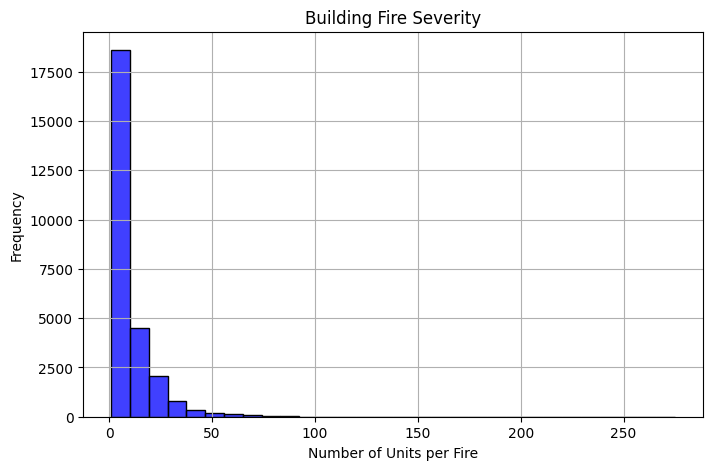

In [465]:
df_building_fire = df_incidents[df_incidents['DESC_GROUP_ENGLISH'] == 'Building fire']

# --- Building Fire Severity Distribution ---
plt.figure(figsize=(8, 5))
sns.histplot(df_building_fire["NOMBRE_UNITES"], bins=30, color="blue")
plt.xlabel("Number of Units per Fire")
plt.ylabel("Frequency")
plt.title("Building Fire Severity")
plt.grid()
plt.show()

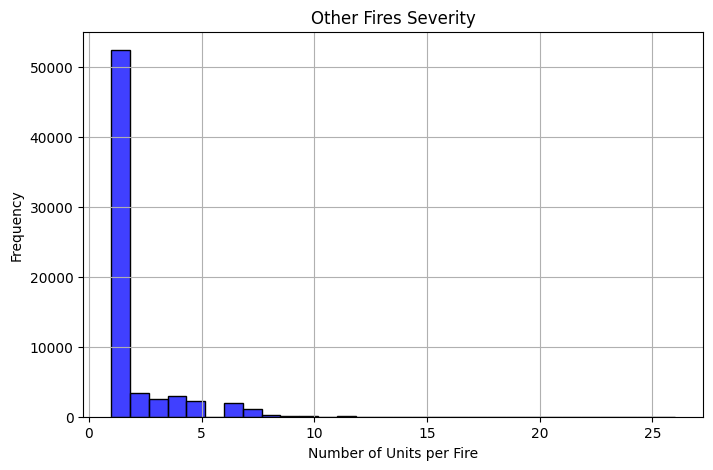

In [466]:
df_other_fires = df_incidents[df_incidents['DESC_GROUP_ENGLISH'] == 'Other fires']

# --- ️Other Fire Severity Distribution ---
plt.figure(figsize=(8, 5))
sns.histplot(df_other_fires["NOMBRE_UNITES"], bins=30, color="blue")
plt.xlabel("Number of Units per Fire")
plt.ylabel("Frequency")
plt.title("Other Fires Severity")
plt.grid()
plt.show()

In [467]:
df_caserne_monthly = df_incidents.groupby(['YEAR', 'MONTH', 'CASERNE']).agg(
  MEDIAN_NOMBRE_UNITES=('NOMBRE_UNITES', 'median'),
  FIRE_COUNT=('CASERNE', 'size'),
).reset_index()
df_caserne_monthly.head()

,YEAR,MONTH,CASERNE,MEDIAN_NOMBRE_UNITES,FIRE_COUNT
0,2005,1,4,8.0,2
1,2005,1,5,4.0,7
2,2005,1,8,3.0,3
3,2005,1,9,4.5,12
4,2005,1,10,8.0,4


In [468]:
df_caserne_monthly[['MEDIAN_NOMBRE_UNITES', 'FIRE_COUNT']].describe()

,MEDIAN_NOMBRE_UNITES,FIRE_COUNT
count,14585.000000,14585.000000
mean,3.170106,6.431334
std,4.060584,4.779931
min,1.000000,1.000000
25%,1.000000,3.000000
50%,1.500000,5.000000
75%,4.000000,9.000000
max,81.000000,49.000000


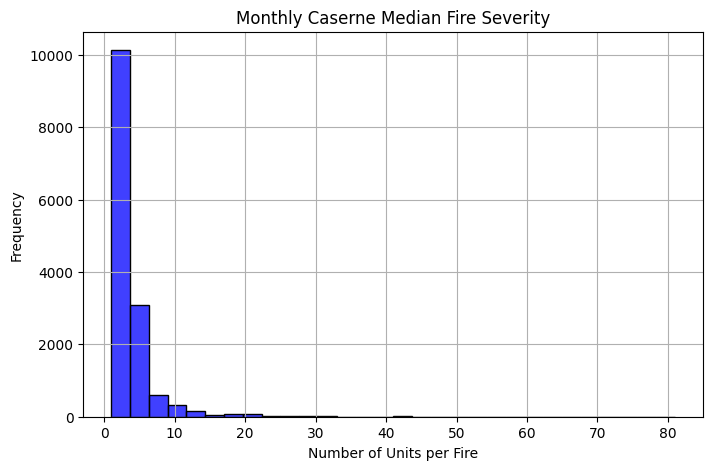

In [469]:
# --- ️Monthly Caserne Median Fire Severity Distribution ---
plt.figure(figsize=(8, 5))
sns.histplot(df_caserne_monthly["MEDIAN_NOMBRE_UNITES"], bins=30, color="blue")
plt.xlabel("Number of Units per Fire")
plt.ylabel("Frequency")
plt.title("Monthly Caserne Median Fire Severity")
plt.grid()
plt.show()

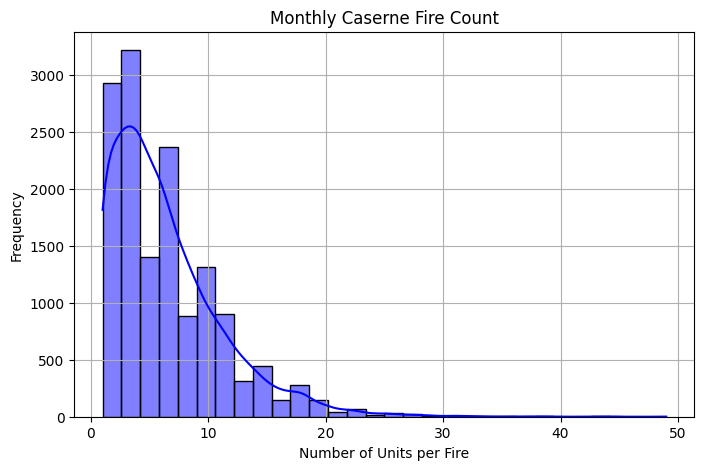

In [470]:
# --- ️Monthly Caserne Fire Count Distribution ---
plt.figure(figsize=(8, 5))
sns.histplot(df_caserne_monthly["FIRE_COUNT"], kde=True, bins=30, color="blue")
plt.xlabel("Number of Units per Fire")
plt.ylabel("Frequency")
plt.title("Monthly Caserne Fire Count")
plt.grid()
plt.show()

In [471]:
df_caserne_area_sq_km = pd.read_csv('caserne-area-sq-km.csv')
df_caserne_area_sq_km.head()

,NO_CAS_ADM,AREA_SQ_KM
0,58,2.28
1,16,2.72
2,35,3.08
3,48,2.28
4,54,9.67


In [472]:
caserne_incidents = pd.Series(df_caserne_monthly['CASERNE'].unique())
caserne_area = pd.Series(df_caserne_area_sq_km['NO_CAS_ADM'].unique())
caserne_incidents[~caserne_incidents.isin(caserne_area)]

,0
57,79


In [473]:
# Dropping all data related to CASERNE No. 79 => Need to find out which territory absorbed it.
df_caserne_monthly = df_caserne_monthly[df_caserne_monthly['CASERNE'] != 79]
df_caserne_risk = pd.merge(df_caserne_monthly, df_caserne_area_sq_km, left_on='CASERNE', right_on='NO_CAS_ADM', how='left')
df_caserne_risk.drop(columns=['NO_CAS_ADM'], inplace=True)
df_caserne_risk['FIRE_COUNT_SQ_KM'] = (df_caserne_risk['FIRE_COUNT'] / df_caserne_risk['AREA_SQ_KM']).round(2)
print(df_caserne_risk.shape)
df_caserne_risk.head()


(14543, 7)


,YEAR,MONTH,CASERNE,MEDIAN_NOMBRE_UNITES,FIRE_COUNT,AREA_SQ_KM,FIRE_COUNT_SQ_KM
0,2005,1,4,8.0,2,5.47,0.37
1,2005,1,5,4.0,7,1.31,5.34
2,2005,1,8,3.0,3,12.33,0.24
3,2005,1,9,4.5,12,9.29,1.29
4,2005,1,10,8.0,4,2.65,1.51


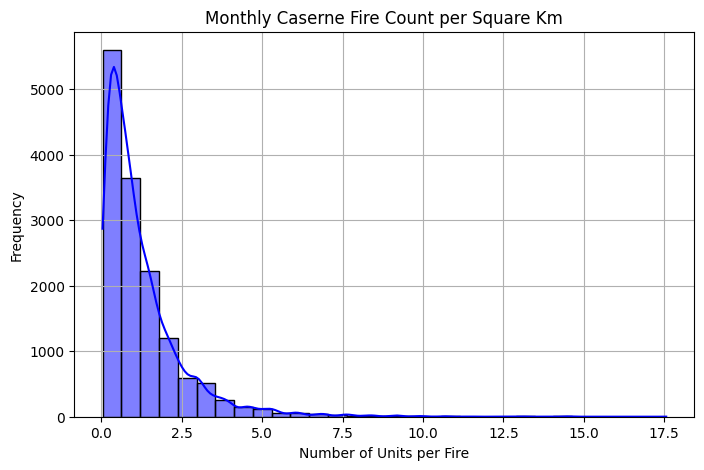

In [474]:
# --- ️Monthly Caserne Fire Count Per Square Km  ---
plt.figure(figsize=(8, 5))
sns.histplot(df_caserne_monthly_area["FIRE_COUNT_SQ_KM"], kde=True, bins=30, color="blue")
plt.xlabel("Number of Units per Fire")
plt.ylabel("Frequency")
plt.title("Monthly Caserne Fire Count per Square Km")
plt.grid()
plt.show()

In [475]:
scaler = MinMaxScaler()
df_caserne_risk[[
  'MEDIAN_NOMBRE_UNITES_NORM',
  'FIRE_COUNT_SQ_KM_NORM'
]] = scaler.fit_transform(df_caserne_risk[['MEDIAN_NOMBRE_UNITES', 'FIRE_COUNT_SQ_KM']])
df_caserne_risk.head()

,YEAR,MONTH,CASERNE,MEDIAN_NOMBRE_UNITES,FIRE_COUNT,AREA_SQ_KM,FIRE_COUNT_SQ_KM,MEDIAN_NOMBRE_UNITES_NORM,FIRE_COUNT_SQ_KM_NORM
0,2005,1,4,8.0,2,5.47,0.37,0.08750,0.018836
1,2005,1,5,4.0,7,1.31,5.34,0.03750,0.302511
2,2005,1,8,3.0,3,12.33,0.24,0.02500,0.011416
3,2005,1,9,4.5,12,9.29,1.29,0.04375,0.071347
4,2005,1,10,8.0,4,2.65,1.51,0.08750,0.083904


In [476]:
df_caserne_risk['RISK_SCORE'] = ((df_caserne_risk['FIRE_COUNT_SQ_KM_NORM'] + df_caserne_risk['MEDIAN_NOMBRE_UNITES_NORM']) / 2).round(2)
df_caserne_risk['RISK_SCORE'] = scaler.fit_transform(df_caserne_risk[['RISK_SCORE']]) * 100
df_caserne_risk.head()

,YEAR,MONTH,CASERNE,MEDIAN_NOMBRE_UNITES,FIRE_COUNT,AREA_SQ_KM,FIRE_COUNT_SQ_KM,MEDIAN_NOMBRE_UNITES_NORM,FIRE_COUNT_SQ_KM_NORM,RISK_SCORE
0,2005,1,4,8.0,2,5.47,0.37,0.08750,0.018836,10.0
1,2005,1,5,4.0,7,1.31,5.34,0.03750,0.302511,34.0
2,2005,1,8,3.0,3,12.33,0.24,0.02500,0.011416,4.0
3,2005,1,9,4.5,12,9.29,1.29,0.04375,0.071347,12.0
4,2005,1,10,8.0,4,2.65,1.51,0.08750,0.083904,18.0


In [477]:
df_caserne_risk['RISK_SCORE'].describe()

,RISK_SCORE
count,14543.000000
mean,9.563914
std,8.352527
min,0.000000
25%,4.000000
50%,8.000000
75%,12.000000
max,100.000000


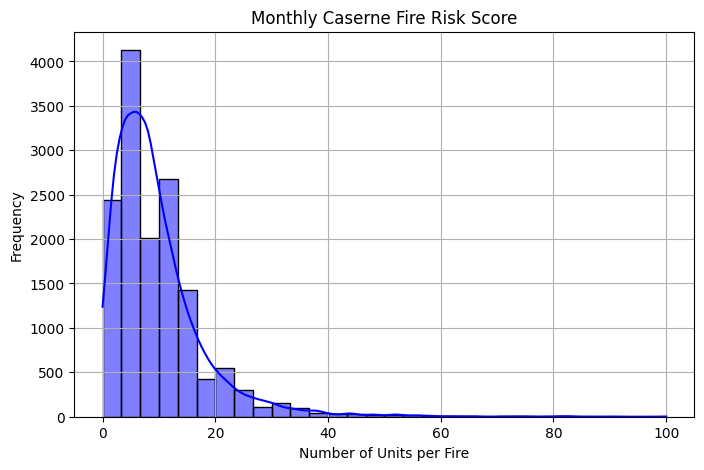

In [478]:
# --- ️Monthly Caserne Fire Risk  ---
plt.figure(figsize=(8, 5))
sns.histplot(df_caserne_risk["RISK_SCORE"], kde=True, bins=30, color="blue")
plt.xlabel("Number of Units per Fire")
plt.ylabel("Frequency")
plt.title("Monthly Caserne Fire Risk Score")
plt.grid()
plt.show()

### Modified Z-Score Formula (Using MAD)

$$
MZ = \frac{0.6745 \times (X_i - \text{Median})}{\text{MAD}}
$$

$MZ>3.5$ → The point is an outlier.

In [479]:
def detect_outliers(data, threshold=3.5):
    median = np.median(data)
    mad = median_abs_deviation(data)
    mod_z_scores = 0.6745 * (data - median) / mad
    outliers = data[np.abs(mod_z_scores) > threshold]
    return outliers

In [480]:
outliers = detect_outliers(df_caserne_risk['RISK_SCORE'])
outliers.describe()

,RISK_SCORE
count,461.000000
mean,40.004338
std,12.299522
min,30.000000
25%,32.000000
50%,36.000000
75%,44.000000
max,100.000000


In [481]:
#df_caserne_risk['RISK_SCORE'] = winsorize(df_caserne_risk['RISK_SCORE'], limits=[0.01, 0.01])
#outliers = detect_outliers(df_caserne_risk['RISK_SCORE'])
#outliers.describe()

In [482]:
df_caserne_risk.to_csv('caserne-risk.csv', index=False)